In [21]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as se
#import regex as re

def startsWithDateTime(s):
    pattern = '^([0-2][0-9]|(3)[0-1])(\/)(((0)[0-9])|((1)[0-2]))(\/)(\d{2}|\d{4}), ([0-9][0-9]):([0-9][0-9])'
    result = re.match(pattern, s)
    if result:
        return True
    return False


def startsWithAuthor(s):
    patterns = [
        '([\w]+):',                        # First Name
        '([\w]+[\s]+[\w]+):',              # First Name + Last Name
        '([\w]+[\s]+[\w]+[\s]+[\w]+):',    # First Name + Middle Name + Last Name
        '([+]\d{2} \d{5} \d{5}):',         # Mobile Number (India)
        '([+]\d{2} \d{3} \d{3} \d{4}):',   # Mobile Number (US)
        '([+]\d{2} \d{4} \d{7})'           # Mobile Number (Europe)
    ]
    pattern = '^' + '|'.join(patterns)
    result = re.match(pattern, s)
    if result:
        return True
    return False

def getDataPoint(line):
    # line = 28/03/19, 2:35 pm - You created group "Tech team farewell🥳🥳"

    splitLine = line.split(' - ') # splitLine = ['28/03/19, 2:35', 'Tarini Tyagi: Why do we have less score']
    
    dateTime = splitLine[0] # dateTime = '28/03/19, 2:35'
    
    date, time = dateTime.split(', ') # date = '28/03/19'; time = '2:35'
    
    message = ' '.join(splitLine[1:]) # message = 'Tarini Tyagi: Why do we have less score'
    
    if startsWithAuthor(message): # True
        splitMessage = message.split(': ') # splitMessage = ['Tarini Tyagi', 'Why do we have less score']
        author = splitMessage[0] # author = 'Tarini Tyagi'
        message = ' '.join(splitMessage[1:]) # message = 'Why do we have less score'
    else:
        author = None
    return date, time, author, message

parsedData = [] # List to keep track of data so it can be used by a Pandas dataframe
conversationPath = 'Techteam.txt' 
with open("Techteam.txt", encoding="utf-8") as fp:
    fp.readline() # Skipping first line of the file (usually contains information about end-to-end encryption)
        
    messageBuffer = [] # Buffer to capture intermediate output for multi-line messages
    date, time, author = None, None, None # Intermediate variables to keep track of the current message being processed
    
    while True:
        line = fp.readline() 
        if not line: # Stop reading further if end of file has been reached
            break
        line = line.strip() # Guarding against erroneous leading and trailing whitespaces
        
        if startsWithDateTime(line): # If a line starts with a Date Time pattern, then this indicates the beginning of a new message
            #print(len(messageBuffer))
            if len(messageBuffer) > 0: # Check if the message buffer contains characters from previous iterations
                parsedData.append([date, time, author, ' '.join(messageBuffer)]) # Save the tokens from the previous message in parsedData
            messageBuffer.clear() # Clear the message buffer so that it can be used for the next message
            date, time, author, message = getDataPoint(line) # Identify and extract tokens from the line
            messageBuffer.append(message) # Append message to buffer
        else:
            messageBuffer.append(line) # If a line doesn't start with a Date Time pattern, then it is part of a multi-line message. So, just append to buffer
        
        
df = pd.DataFrame(parsedData, columns=['Date', 'Time', 'Author', 'Message'])
df.head()

df.describe()

,Date,Time,Author,Message
count,316,316,316,317
unique,27,154,20,221
top,26/04/19,12:00 pm,Tarini Tyagi,<Media omitted>
freq,68,9,110,40


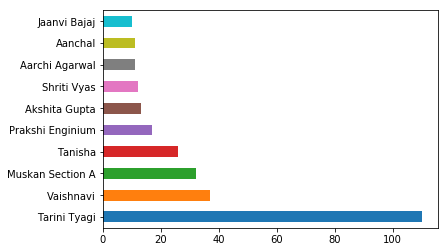

In [22]:
# Plotting Number of messages per author for the top 10 most active authors
author_value_counts = df['Author'].value_counts() # Number of messages per author
top_10_author_value_counts = author_value_counts.head(10) # Number of messages per author for the top 10 most active authors
top_10_author_value_counts.plot.barh() # Plot a bar chart using pandas built-in plotting apis


In [23]:
#Let us find all those messages which have no authors
null_authors_df = df[df['Author'].isnull()]
null_authors_df.head()

,Date,Time,Author,Message
0,None,None,None,"28/03/19, 2:35 pm - You created group ""Tech te..."


        Date      Time        Author          Message
8   10/04/19  12:04 pm       Aanchal  <Media omitted>
9   10/04/19  12:04 pm       Aanchal  <Media omitted>
10  10/04/19  12:04 pm       Aanchal  <Media omitted>
11  10/04/19  12:04 pm       Aanchal  <Media omitted>
14  12/04/19  12:00 pm  Tarini Tyagi  <Media omitted>


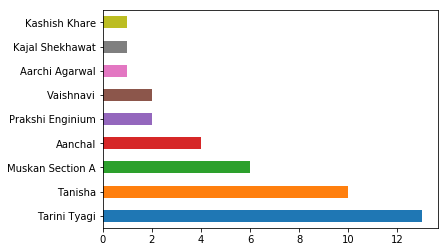

In [24]:
#Let us find all media messages and analyze the number of media messages sent by the top 10 authors 
media_messages_df = df[df['Message'] == '<Media omitted>']
print(media_messages_df.head())

author_media_messages_value_counts = media_messages_df['Author'].value_counts()
top_10_author_media_messages_value_counts = author_media_messages_value_counts.head(10)
top_10_author_media_messages_value_counts.plot.barh()

In [25]:
#dropping all those messages that are either media messages or do not have an author
messages_df = df.drop(null_authors_df.index) # Drops all rows of the data frame containing messages from null authors
messages_df = messages_df.drop(media_messages_df.index) # Drops all rows of the data frame containing media messages
messages_df.head()

,Date,Time,Author,Message
1,28/03/19,11:01 pm,Aanchal,Vaise April end tk hi aaegi boss
2,28/03/19,11:57 pm,Vaishnavi,Han wahi
3,10/04/19,11:16 am,Vaishnavi,Kya plan h guys ?
4,10/04/19,11:25 am,Akshita Gupta,3 seniors
5,10/04/19,11:26 am,Akshita Gupta,3rd yr 6


In [32]:
#It might be interesting to count the number of letters and words used by each author in each message. So, let us add 2 new columns to the data frame called “Letter_Count” and “Word_Count”
messages_df['Letter_Count'] = messages_df['Message'].apply(lambda s : len(s))
messages_df['Word_Count'] = messages_df['Message'].apply(lambda s : len(s.split(' ')))
discrete_columns = ['Date', 'Time', 'Author', 'Message']
messages_df[discrete_columns].describe()

,Date,Time,Author,Message
count,276,276,276,276
unique,27,144,19,219
top,26/04/19,12:14 pm,Tarini Tyagi,Okay boss
freq,57,8,97,27


In [33]:

continuous_columns = ['Letter_Count', 'Word_Count']
messages_df[continuous_columns].describe()

,Letter_Count,Word_Count
count,276.000000,276.000000
mean,159.699275,29.134058
std,536.447480,95.365975
min,1.000000,1.000000
25%,9.000000,2.000000
50%,24.000000,5.000000
75%,52.750000,11.000000
max,4488.000000,774.000000


In [34]:
#How many words and letters have been sent since the beginning of time
messages_df['Letter_Count'].sum(), messages_df['Word_Count'].sum()

(44077, 8041)

Text(0,0.5,'Authors')

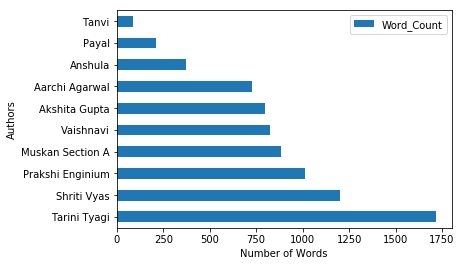

In [35]:
# How many words have been sent in total by each author, since the beginning of time?
total_word_count_grouped_by_author = messages_df[['Author', 'Word_Count']].groupby('Author').sum()
sorted_total_word_count_grouped_by_author = total_word_count_grouped_by_author.sort_values('Word_Count', ascending=False)
top_10_sorted_total_word_count_grouped_by_author = sorted_total_word_count_grouped_by_author.head(10)
top_10_sorted_total_word_count_grouped_by_author.plot.barh()
plt.xlabel('Number of Words')
plt.ylabel('Authors')

Text(0,0.5,'Frequency')

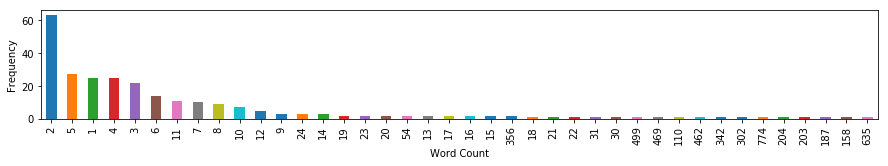

In [36]:
#What is the most common number of words in a message?
plt.figure(figsize=(15, 2)) # To ensure that the bar plot fits in the output cell of a Jupyter notebook
word_count_value_counts = messages_df['Word_Count'].value_counts()
top_40_word_count_value_counts = word_count_value_counts.head(40)
top_40_word_count_value_counts.plot.bar()
plt.xlabel('Word Count')
plt.ylabel('Frequency')

Text(0,0.5,'Authors')

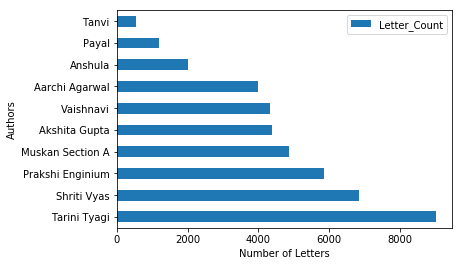

In [37]:
# Looks like most messages contain only 1 word. I wonder what that word is!
#  the total number of letters sent by each author
total_letter_count_grouped_by_author = messages_df[['Author', 'Letter_Count']].groupby('Author').sum()
sorted_total_letter_count_grouped_by_author = total_letter_count_grouped_by_author.sort_values('Letter_Count', ascending=False)
top_10_sorted_total_letter_count_grouped_by_author = sorted_total_letter_count_grouped_by_author.head(10)
top_10_sorted_total_letter_count_grouped_by_author.plot.barh()
plt.xlabel('Number of Letters')
plt.ylabel('Authors')

Text(0,0.5,'Date')

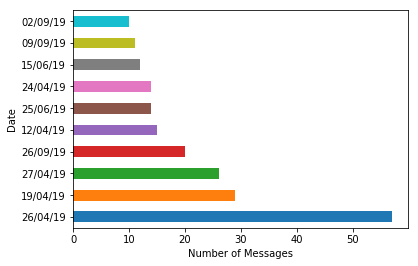

In [38]:
# Do you know the date on which the most number of messages were sent in the history of your group? 
messages_df['Date'].value_counts().head(10).plot.barh() # Top 10 Dates on which the most number of messages were sent
plt.xlabel('Number of Messages')
plt.ylabel('Date')

Text(0,0.5,'Time')

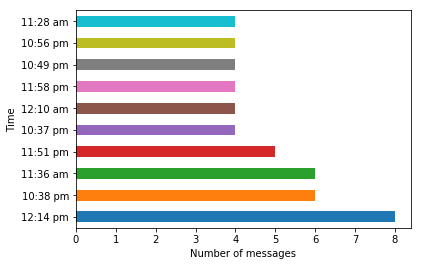

In [39]:
# Do you lie awake at night wondering at what time of the day your group is most active?
messages_df['Time'].value_counts().head(10).plot.barh() # Top 10 Times of the day at which the most number of messages were sent
plt.xlabel('Number of messages')
plt.ylabel('Time')

Text(0,0.5,'Hour of Day')

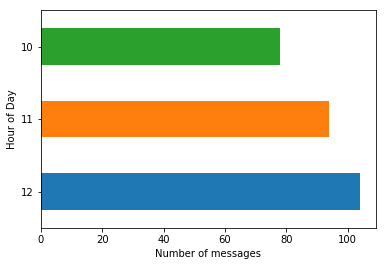

In [41]:
# What is the most suitable hour of the day at which to message to increase your chances of getting a response from someone?
messages_df['Hour'] = messages_df['Time'].apply(lambda x : x.split(':')[0]) # The first token of a value in the Time Column contains the hour (Eg., "20" in "20:15")
messages_df['Hour'].value_counts().head(10).sort_index(ascending=False).plot.barh() # Top 10 Hours of the day during which the most number of messages were sent
plt.xlabel('Number of messages')
plt.ylabel('Hour of Day')

In [ ]:
# This shows messages send at 12:00 has the highest chances of eliciting responses from group members
